This notebook is the implementation of SVD bond compression in tensor networks

Useful shortcut:
M -> convert code cell to markdone to be folded up and deactivated
Y -> convert deactived cell to active code

In [2]:
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using LaTeXStrings
Makie.inline!(true)

true

__Truncated SVD replacement:__

-> function which acts on a TensorNetwork by taking in a specific bondindex and a bondsize, this bond index will be truncated towards the specified bondsize by bond compression.

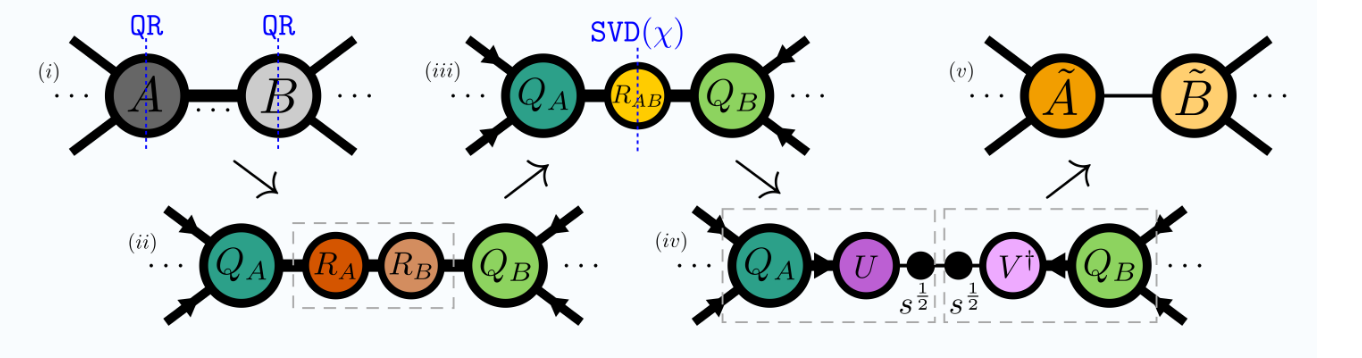

In [3]:
function truncated_SVD_replacement(tn, index, bondsize, printing=false)

    """ Function which takes in a TensorNetwork and an index which connect two tensors inside of this network.
    This function applies truncated SVD bond-compression through grouping of R-tensors from QR decomposition on the bond.
    Return the TensorNetwork with relevant modification made to bond tensors connected to this index.

    Graphical description of what the code does:

    == ~ Initial bond
    -- ~ Truncated bond

    A  == B
    Q1 == R1 == R2 == Q2 
    Q1 == R12 == Q2 
    Q1 == U == S == Vt == Q2 
    [Q1 == U  -- s12] -- [s12 -- Vt == Q2] 
    new_A -- new_B

    """ 
    
    # select both tensors connected to the index
    tensor1, tensor2 = Tenet.select(tn, (Symbol(index)))
    
    if length(inds(tensor1)) == 1
        println("One of the tensors has no non shared indices. Exiting function.")
        return  # This will exit the function prematurely
    end
    if length(inds(tensor2)) == 1
        println("One of the tensors has no non shared indices. Exiting function.")
        return  # This will exit the function prematurely
    end

    if printing == true
        println(inds(tensor1))
        println(inds(tensor2))
        println("bond index=", intersect(inds(tensor1), inds(tensor2)))
        println("The size of tensor1 =", size(tensor1))
        println("The size of tensor2 =", size(tensor2))
    end

    # extract the common and complimentairy indices
    common_index = Set([(index)])  # Convert to Set
    complementind_T1 = setdiff(inds(tensor1), common_index)
    complementind_T2 = setdiff(inds(tensor2), common_index)



    if printing == true
        println("complement ind T1 and T2")
        println(complementind_T1)
        println(complementind_T2)
    end


    # Perform a QR-decomposition on both tensors in the bond in a way that the R -factors are pushed towards the middle of the bond
    Q1, R1 = LinearAlgebra.qr(tensor1, left_inds = (complementind_T1...,))
    Q2, R2 = LinearAlgebra.qr(tensor2, left_inds = (complementind_T2...,))

    if printing == true
        # sizes and corresponding indices in the Q, R tensors
        println("Q1 Tensor = ", size(Q1), inds(Q1))
        println("R1 Tensor = ", size(R1), inds(R1))
        println("Q2 Tensor = ", size(Q2), inds(Q2))
        println("R2 Tensor = ", size(R2), inds(R2))
    end

    # Perform a SVD-decomposition on the R12 tensor -> truncation of the S - matrix will allow one to make an approximation to the network

    new_bond = string(index)*"_*"




    R12 = Tenet.contract(R1, R2)

    # Some-decission making based on the tensor R12
    # As the amount of singular values on the bond is given by the dimensions of the legs coming out of the R12 tensor and not by the size of the bond in the network....
    if bondsize > minimum([size(R12, ix) for ix in inds(R12)])
        return  # Exit the function prematurely and don't Perform the SVD-> truncation as the amount of singular values are to small compared to the bondsize
    end

    Q1_inds = intersect(inds(Q1), inds(R12)) #extract the indices pointing towards Q1
    U, S, Vt = LinearAlgebra.svd(R12, left_inds = (Q1_inds...,))
    s12 = size_up_and_reconnect(S, Symbol(new_bond))

    if printing == true
        println("R12 Tensor = ", size(R12), inds(R12))
        println("U Tensor = ", size(U), inds(U))
        println("S Tensor = ", size(S), inds(S))
        println("s12 Tensor = ", size(s12), inds(s12))
        println("Vt Tensor = ", size(Vt), inds(Vt))
    end

    # Rescale the intersecting dimension in U and s12
    common_id1 = intersect(inds(U), inds(s12))
    common_id2 = intersect(inds(Vt), inds(s12))

    # print("The characteristics of s12:", size(s12), inds(s12))
    # Cut all the relevant tensors towards the size specified by the bondsize argument
    s12 = tensor_cutting_index!(s12, Symbol(common_id1[1]), bondsize)
    s12 = tensor_cutting_index!(s12, Symbol(new_bond), bondsize)
    # here is the problem --> The network already has this index with this specific size associated with it... how to delete this from tensor information
    U = tensor_cutting_index!(U, Symbol(common_id1[1]), bondsize)
    s12 = tensor_cutting_index!(s12, Symbol(common_id2[1]), bondsize)
    s12 = tensor_cutting_index!(s12, Symbol(new_bond), bondsize)

    Vt = tensor_cutting_index!(Vt, Symbol(common_id2[1]), bondsize)

    # compute the new tensors
    A_new = Tenet.contract(Q1,Tenet.contract(U, s12))
    B_new = Tenet.contract(Q2, Tenet.contract(Vt, s12))

    if printing == true
        println("computing new A")
        println("sizes:",size(Q1), size(U), size(s12))
        println("indices:",inds(Q1), inds(U), inds(s12))
        println("A_new computed")
        println("Size difference:", size(tensor1), size(A_new))
        println("Index difference:", inds(tensor1), inds(A_new))
        
    end   

    if printing == true
        println("computing B new")
        println("sizes:",size(Q2), size(Vt), size(s12))
        println("indices:",inds(Q2), inds(Vt), inds(s12))
        println("B_new computed")
        println("Size difference:", size(tensor2), size(B_new))
        println("Index difference:", inds(tensor2), inds(B_new))
    end

    # Replacing the relevant things inside of the TN    
    pop!(tn, tensor1)
    push!(tn, A_new)
    pop!(tn, tensor2)
    push!(tn, B_new)
    replace!(tn, Symbol(new_bond) => index)   # Perform index renaming back to the original name --> If this insn't done, big error
    return 

end

truncated_SVD_replacement (generic function with 2 methods)

__Grouping bond indices:__

-> Function whcih takes in indices to group and restructures the connected tensors in a way that the relevant indices are grouped to a single index with grouped_index_size = prod(index_sizes)

![Screenshot from 2023-12-09 13-23-34.png](<attachment:Screenshot from 2023-12-09 13-23-34.png>)
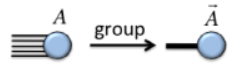

In [4]:
function grouping_bondindices(tn, indices_to_group, printing=false)

    """ 
    Matricization of a tensor involves rearranging the data of a tensor into a matrix form based on a specific grouping of indices.
    Matricization allows the contraction process to be better understood as pairwise contractions.
    This function takes in a TensorNetwork and a list of indices insize this network which should be grouped together
    """

    # Compute the dimension of the new bond -> this new bond has the size of the product of the grouped dimensions

    tensor1, tensor2 = Tenet.select(tn, indices_to_group) # take out the tensors which are relevant to this bond
    dim_new = prod(size(tn, index) for index in indices_to_group) # compute the dimension of the new grouped bond

    # compute the indices to leave ungrouped
    complementind_T1 = setdiff(inds(tensor1), indices_to_group)
    complementind_T2 = setdiff(inds(tensor2), indices_to_group)

    # generate a permutation order of indices which puts the to group indices in the end
    # by reshaping the underlying data array -> (dim(complementind_T1)..., dim_new) the correct parts of the data array are grouped

    new_order1 = [complementind_T1..., indices_to_group...] # indices to keep at front
    new_order2 = [complementind_T2..., indices_to_group...] # indices to group at the back
    
    # Permute the dimensions based on the new order
    permuted_tensor1 = permutedims(tensor1, new_order1)
    permuted_tensor2 = permutedims(tensor2, new_order2)

    # extract the permuted tensor data to be reshaped
    new_tensor1_data_array = permuted_tensor1.data
    new_tensor2_data_array = permuted_tensor2.data

    # perform the reshaping and create new tensors with grouped index
    new_index = join([string(index) for index in indices_to_group], "")
    
    # create reshape lists -> casted to tuple for the reshape function
    # reshape lists are based on sizes of the underlying data arrays
    # vcat vertically concatenates two arrays

    tensor1_reshape_list = vcat([size(tensor1, Symbol(id)) for id in complementind_T1], dim_new)
    tensor2_reshape_list = vcat([size(tensor2, Symbol(id)) for id in complementind_T2], dim_new)

    # Create the new tensors based on the the reshaped data array and on a tuple containing the untouched indices and the newly grouped index

    tensor1_new = Tensor(reshape(new_tensor1_data_array, (tensor1_reshape_list...)), (complementind_T1..., Symbol(new_index)))
    tensor2_new = Tensor(reshape(new_tensor2_data_array, (tensor2_reshape_list...)), (complementind_T2..., Symbol(new_index)))
    if printing == true
        println("First replaced tensor sizes ", size(tensor1), "==>", size(tensor1_new), "where ", inds(tensor1), "==>", inds(tensor1_new))
        println("Second replaced tensor sizes ", size(tensor2), "==>", size(tensor2_new), "where ", inds(tensor2), "==>", inds(tensor2_new))
    end  

    # Modify the tesnor network by replacing the old tensors with the new tensors where they have a grouped bond
    pop!(tn, tensor1)
    push!(tn, tensor1_new)
    pop!(tn, tensor2)
    push!(tn, tensor2_new)
   

    indices_mapping = Dict{String, String}()  # Specify the type of the keys and values

    for index in indices_to_group
        indices_mapping[string(index)] = new_index
    end

    return indices_mapping
   
end

grouping_bondindices (generic function with 2 methods)

__Approximate_contraction:__
-> This function takes in a TensorNetwork, a maximal bond dimension, a list of contraction indices.

Sketch of how the approximate_contraction algorithm will work, it takes in a list of indices and a tensor network

-> Iterates over this list of indices and pops the first index:

1. Checks if this index is present in the network.
2. If this index is present, select the two tensors it connects to
3. Compute the intersecting indices between the two tensors
4. If they share more than 1 common index => group indices in the network and use the grouping dictionary to update the contraction sequence
5. Pop out the old contraction indices of the list of contract order
6. Before contracting the two tensors, check that the dimension of the grouped indices between the two tensors if less than the prespecified bondsize
7. If the size of the index to be contracted over is bigger than the size of the maximal bondsize, perform a truncated_SVD_replacement on this bond
8. Contract the two tensors

Repeat these steps for the whole list of contraction indices


In [5]:
function approximate_contraction(tn, max_chi, list_of_contraction_indices, visualisation = false, svd_printing = false)
    """ 
    
    Function takes in a TensorNetwork, a maximal allowed bondsize and a sequence of contraction indices.
    It uses pairwise approximate contraction based on SVD truncation to max_chi on the bond following a contraction a sequence of indices.
    It generates a mapping of indices to new indices when the need for bondgrouping arrises and updates the contraction path when needed.
    
    """
    
    for i in 1:length(tensors(tn))
        # Select both tensors connected to the index
        active_index = list_of_contraction_indices[i]
        tensor1, tensor2 = Tenet.select(tn, (Symbol(active_index)))

        # Check how many shared indices there are between the two tensors.
        shared_indices = intersect(inds(tensor1), inds(tensor2))
        #println(shared_indices, length(shared_indices))

        if length(shared_indices) > 1
            index_map = grouping_bondindices(tn, shared_indices)
            for index in keys(index_map)
                replace!(list_ordered_contraction_indices, index => index_map[index])
                active_index = index_map[index]
            end
            # Modify the original list in place to remove duplicates -> some indices get mapped to the same grouped index, remove the duplicates
            unique!(list_ordered_contraction_indices)
        end


        # Check if the bondsize is larger than what we want -> if condition is met compress the bond
        #println("The size of the active index is = ", size(tn, Symbol(active_index)))
        if size(tn, Symbol(active_index)) > max_chi
            #println("Performing truncated SVD to chi = $max_chi")
            truncated_SVD_replacement(tn, Symbol(active_index), max_chi, svd_printing)
        end

        # Contracting the network along the active index
        tensor1, tensor2 = Tenet.select(tn, Symbol(active_index))

        contracted = Tenet.contract(tensor1, tensor2)
        # Replacing the relevant things inside of the TN    
        pop!(tn, tensor1)
        pop!(tn, tensor2)
        push!(tn, contracted)
        if length(tensors(tn)) == 1
            return (tensors(tn)[1][1])
        end
        # Visualisation of the contraction step

        if visualisation == true && length(tensors(tn)) > 1
            #println("generating plot")
            # Make a drawing of the tensor network
            # -> Takes a long long time for larger networks...
            drawing1 = Makie.plot(tn, labels=true)
            display(drawing1)
        end
        
    end
        
end

approximate_contraction (generic function with 3 methods)

This function will be a prototype tensornetwork generator in Tenet for an ising model -> some helper functions are defined below

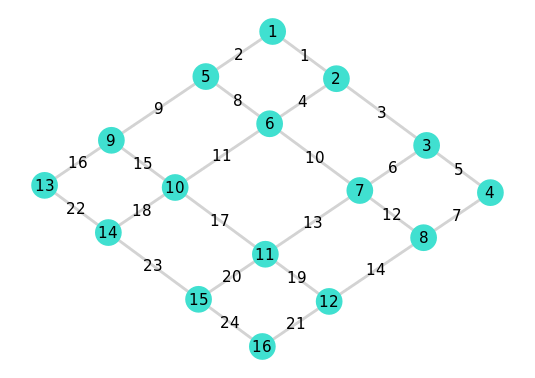

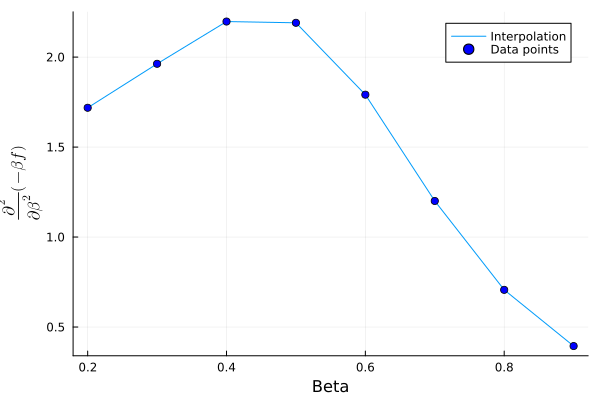

In [20]:
function TN2D_classical_ising_partition_function(Nx::Int, Ny::Int, beta, plotting=false)
    
    """ 
    Function which creates a ferromagnetic (j=1) classical ising model partition function on a square grid.
    Takes in the sizes of the IsingModel Nx, Ny and β.
    Function returns a Tenet TensorNetwork
    """

    # boltzman matrix
    B = [exp(beta) exp(-beta); exp(-beta) exp(beta)]
    sqrtB = convert(Matrix{Float64}, B^(1/2)) ### USE THE CONVERT BECAUSE JULIA HAS ALL THE TYPES OF OBJECTS? -> works
    # sqrtB = B^(1/2) # -> doesn't work -> Symetric? 

    # creating the building blocks of the ising tensor network
    # getting to know einsum notation in Jutho's tensor operations

    # Generating the relevant data arrays -> A2 = corner Tensor, A3 = edge Tensor, A4 = bulk Tensor
    @tensor begin
        A2[i,j] := sqrtB[i,k]*sqrtB[k,j] #contraction along k
        
        ### JULIA HAS INDICES STARTING AT ONE !!!!!!!!!!!!!!!!!!!!!!! STOP FORGETTING
        A3[i,j,k] := sqrtB[:,1][i]*sqrtB[:,1][j]*sqrtB[:,1][k] + sqrtB[:,2][i]*sqrtB[:,2][j]*sqrtB[:,2][k] #is this the easiest way to do an outer product?
        A4[i,j,k,l] := sqrtB[:,1][i]*sqrtB[:,1][j]*sqrtB[:,1][k]*sqrtB[:,1][l] + sqrtB[:,2][i]*sqrtB[:,2][j]*sqrtB[:,2][k]*sqrtB[:,2][l]

    end 


    tensors = []

    ## the layout structure --> Use the Graphs.jl package for underlying functionality... Don't code it all yourself

    n_tensors = Nx*Ny
    n_edges = 2*Nx*Ny - Nx - Ny
    G = Graphs.grid([Nx,Ny])
    nvertices = nv(G) # number of vertices
    nedges = ne(G)    # number of edges

    nodes = [node for node in vertices(G)]
    nodes_labels = [[i,j] for i in 1:Nx for j in 1:Ny]
    nodes_map = Dict(zip(nodes, nodes_labels)) # Create a mapping dict
    edgesgraph = [edge for edge in edges(G)]
    edges_labels = [Symbol(edge) for edge in 1:nedges]
    edges_map = Dict(zip(edgesgraph, edges_labels))

    if plotting == true
        display(gplot(G, nodelabel=nodes, edgelabel=1:n_edges, layout=spectral_layout))
    end


    
    # Generating the tensors inside of the network
    for source in vertices(G)
        inds = Tuple([edges_map[edge] for edge in edges(G) if source in([src(edge), dst(edge)])])
        if length(inds) == 2
            push!(tensors, Tensor(A2, inds))
        end
        if length(inds) == 3
            push!(tensors, Tensor(A3, inds))
        end
        if length(inds) == 4
            push!(tensors, Tensor(A4, inds))
        end   
        
    end

    ising_network = TensorNetwork(tensors)
    return ising_network

    # Generate a TensorNetwork based on all the tensors in the list of tensors
    # Return this as a Tenet tensor network object
end



Nx = 4
Ny = 4

ising_classical2dTN = TN2D_classical_ising_partition_function(Nx, Ny, 0.44, true)
# transform to trivertex - structure
for tensor in tensors(ising_classical2dTN)
    rank = length(inds(tensor))
    if rank > 3 #remove the bulk tesnors and replace them with new SVD-ed tensors
        pop!(ising_classical2dTN, tensor)
        U,S,V = LinearAlgebra.svd(tensor, left_inds=inds(tensor)[2:3])
        push!(ising_classical2dTN, U)
        push!(ising_classical2dTN, S)
        push!(ising_classical2dTN, V)
    end
end
drawing1 = Makie.plot(ising_classical2dTN, node_color=[:darkred for i in 1:length(tensors(ising_classical2dTN))], labels=true, layout=Stress(), edge_color=:grey80)

display(drawing1)

## check that the ising has properties that we are looking for
function compute_second_derivative(arr, h=beta_list[2] - beta_list[1])
    """
    Compute the discrete second derivative of an array using central differences.

    Parameters:
    - arr: 1D array
        Input array.
    - h: float, optional
        Step size for central differences. Default is the difference between the second and first elements of beta_list.

    Returns:
    - second_derivative: 1D array
        Array containing the computed second derivatives.
    """
    n = length(arr)
    second_derivative = zeros(n)

    for i in 2:n-1
        second_derivative[i] = (arr[i+1] - 2*arr[i] + arr[i-1]) / h^2
    end

    return second_derivative
end


beta_list = [0.1*i for i in 1:10]
ising_model_result_list = []

for beta_active in beta_list
    tn_active = TN2D_classical_ising_partition_function(Nx, Ny, beta_active)
    push!(ising_model_result_list, log(Tenet.contract(tn_active)[1])/(length(tensors(tn_active))))
end


result_2nd_diff = compute_second_derivative(ising_model_result_list)
latex_expression = "\$\\frac{\\partial^2}{\\partial\\beta^2}\\left(-\\beta f\\right)\$"





plot_data = Plots.plot(beta_list[2:end-1], result_2nd_diff[2:end-1], label="Interpolation") #broadcast in onto the relative erorrs instead of calling the function
Plots.plot!(plot_data, beta_list[2:end-1], result_2nd_diff[2:end-1], seriestype=:scatter, label="Data points", color="blue")
Plots.xlabel!(plot_data,  "Beta")
Plots.ylabel!(plot_data, latex_expression)
# Display the plot
display(plot_data)










__Some helper functions:__

-> adapt other functions to have these functionalities build in





In [6]:
function contraction_step(tn, bond_index)

    """ Helper function to allow contraction of the tensor network along a specified index """
    
    if length(inds(tn)) == 0
        return
    end

    tensor1, tensor2 = Tenet.select(tn, bond_index)

    contracted = Tenet.contract(tensor1, tensor2)
    # Replacing the relevant things inside of the TN    
    pop!(tn, tensor1)
    pop!(tn, tensor2)
    push!(tn, contracted)
        
    

end


function generate_groupedbonds(tn)

    """ Generates a dictionary containing as keys lists of bond-indices between two tensors and as vals the tensors in connecting the bonds """

    result_dict = Dict{Vector, Vector}()

    for id in inds(tn)
        tensor1, tensor2 = Tenet.select(tn, (Symbol(id)))
        common_indices = intersect(inds(tensor1), inds(tensor2))
        result_dict[common_indices] = [tensor1, tensor2]
    end

    return keys(result_dict)

end


function size_up_and_reconnect(S, index)
    """ This helper function takes in tensor S from the SVD and splits it in two -> two times s^(1/2) reconnects them with the index of the bond """

    s12_data = S.data.^(1/2)
    s12_data_matrix = LinearAlgebra.diagm(s12_data)
    s12_indices = [inds(S)..., Symbol(index)]
    s12_tensor = Tensor(s12_data_matrix, (s12_indices...,))

    return s12_tensor

end

function tensor_cutting_index!(tensor, index, bondsize)
    """ Function which takes in a tensor, a symbolic index and a bondsize. Reduces the dimension of this index towards bondsize """
    
    slice_location = dim(tensor, index)
    # Create a tuple of slices for each dimension
    slices = [1:size(tensor, dim) for dim in 1:ndims(tensor)]
    # Replace the slice for the specified dimension with the desired range
    slices[slice_location] = 1:bondsize
    # Create a new tensor with the same indices, but the data is rescaled along one dimension
    tensor = Tensor(tensor[slices...], inds(tensor))
    return tensor

end

tensor_cutting_index! (generic function with 1 method)

From this part in the notebook I'll start defined some netwrok and try out some of the methods for testing purposes:

This block generates a random tensor network and performs:
1. Bond grouping on the whole network
2. Bond compression on all indices

Afterwards, the contraction values of the approximated network is compared with the contraction value of the exact contraction

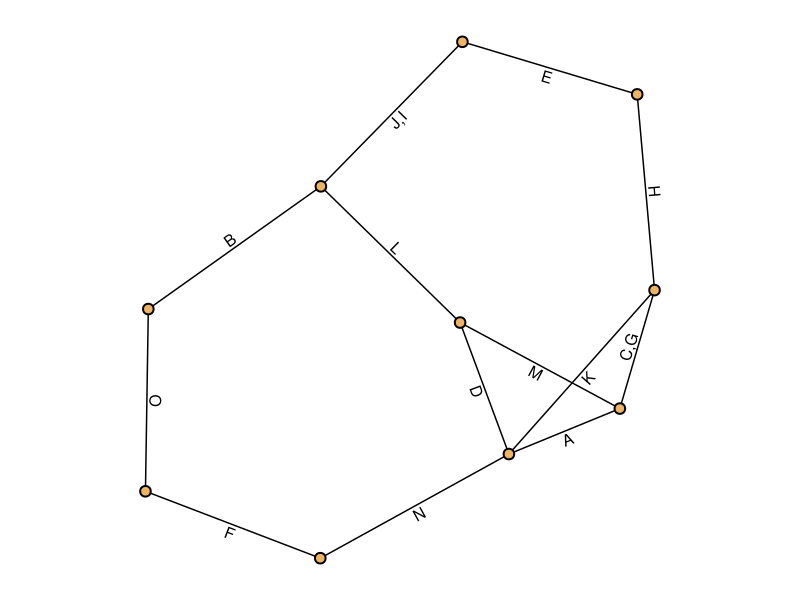

Tensor network generated=TensorNetwork(#tensors=10, #inds=15)
Generating plot....
Preparing the TensorNetwork for compressed contraction
Performing bond grouping on the whole network
The bond-grouped network:
Value of initial network contraction = 1.091823412434269e6
Value of contraction after bondgrouping = 1.091823412434269e6
Value of contraction after truncated_SVD_replacement = 1.0918234124342683e6
The relative error of approximate contraction = 6.661338147750939e-16


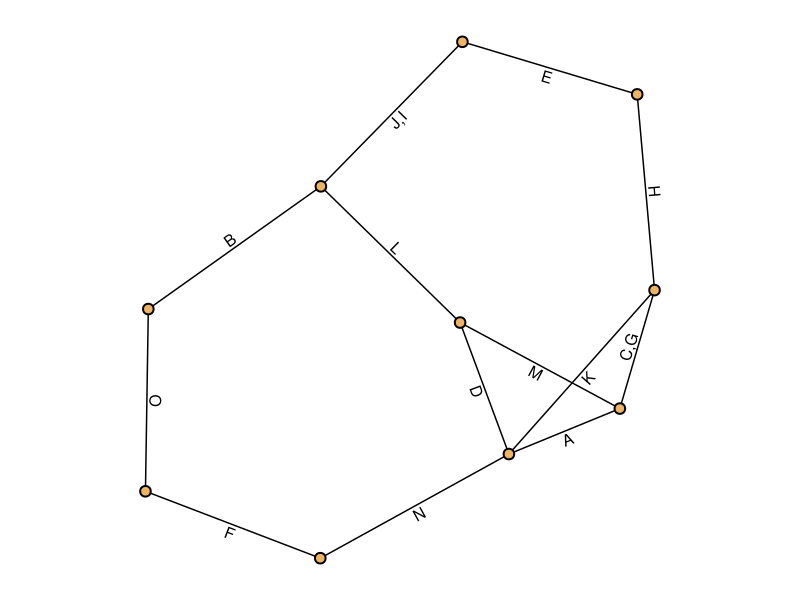

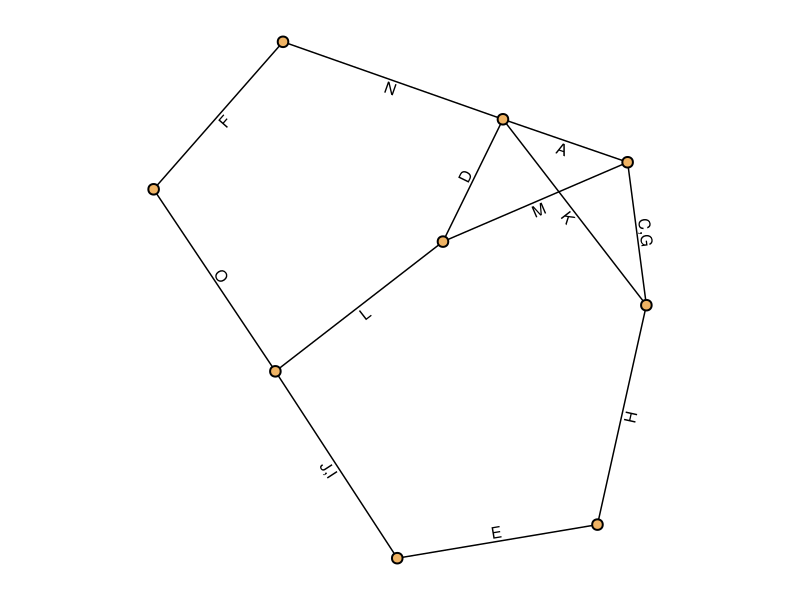

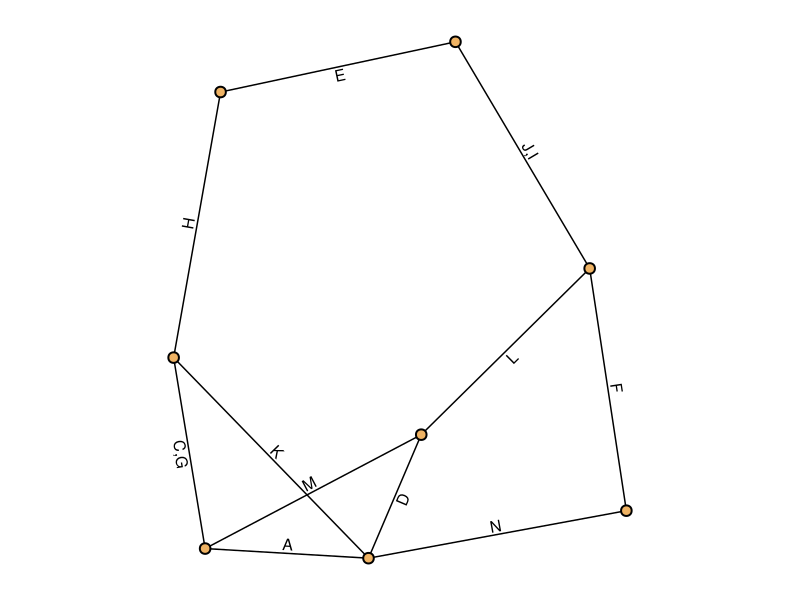

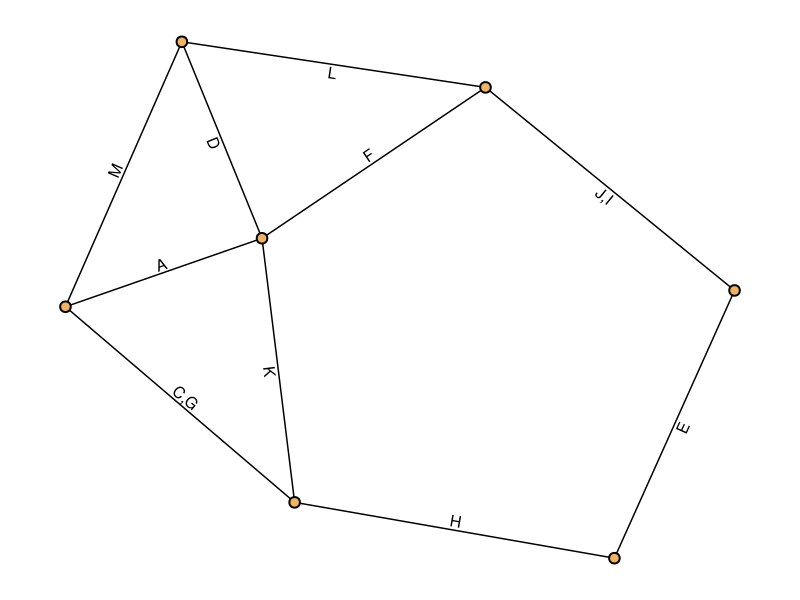

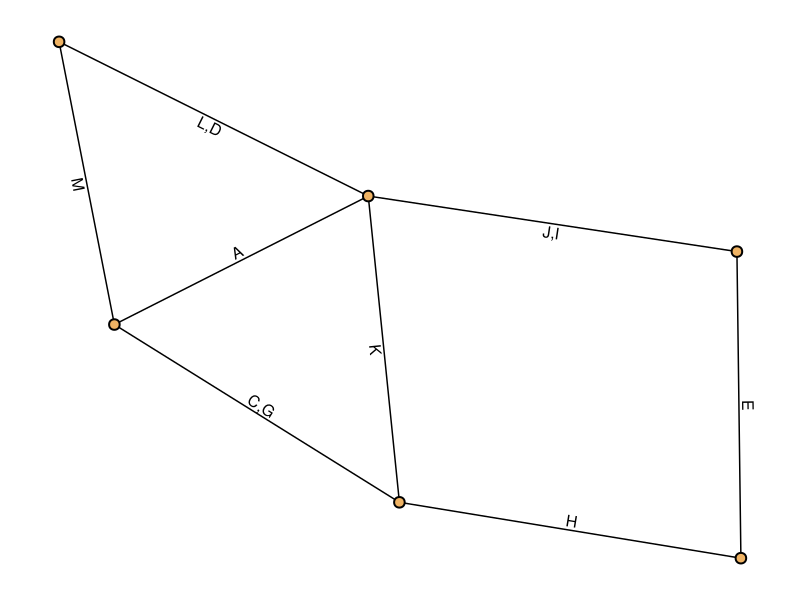

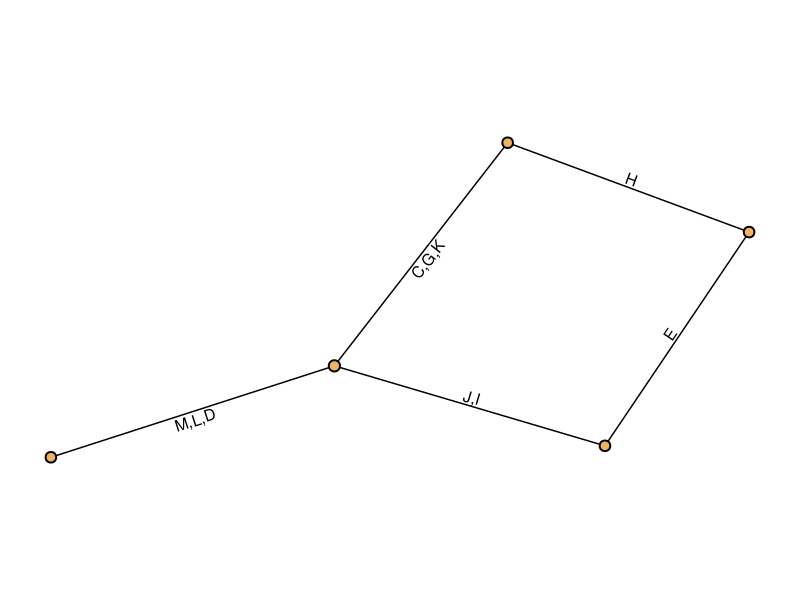

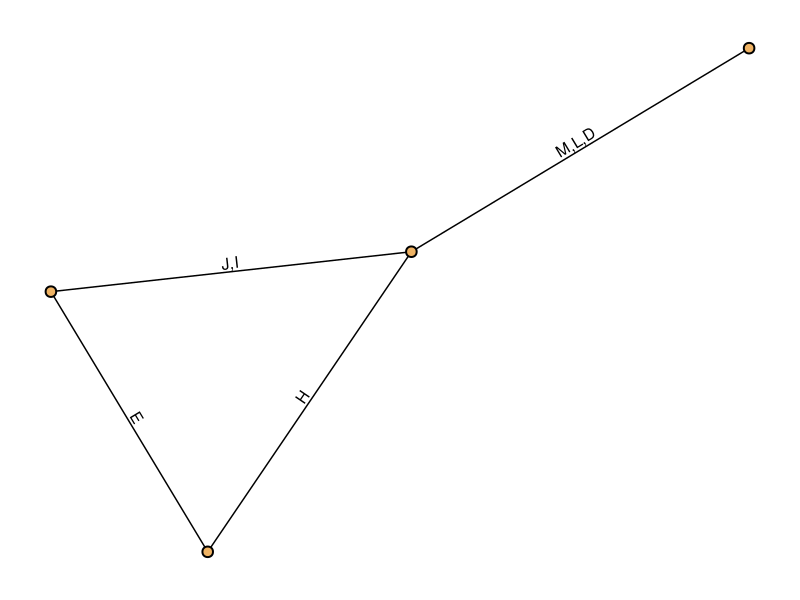

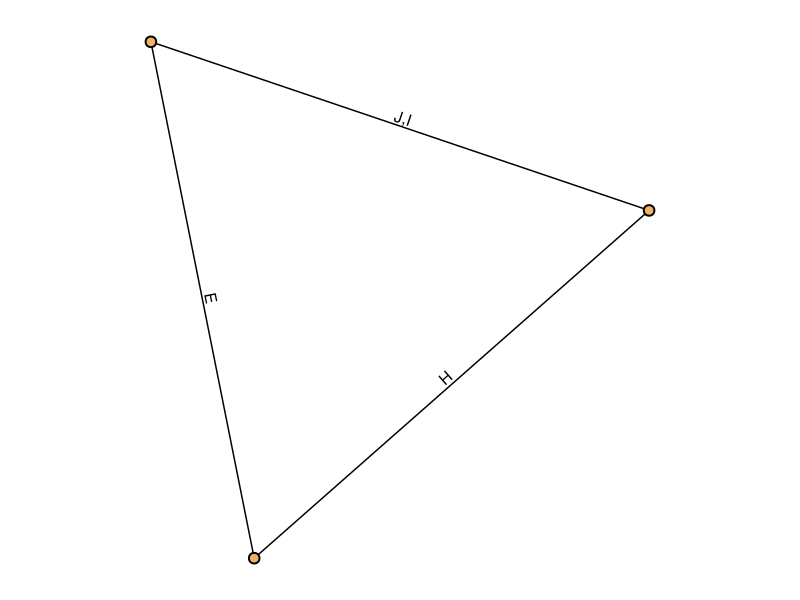

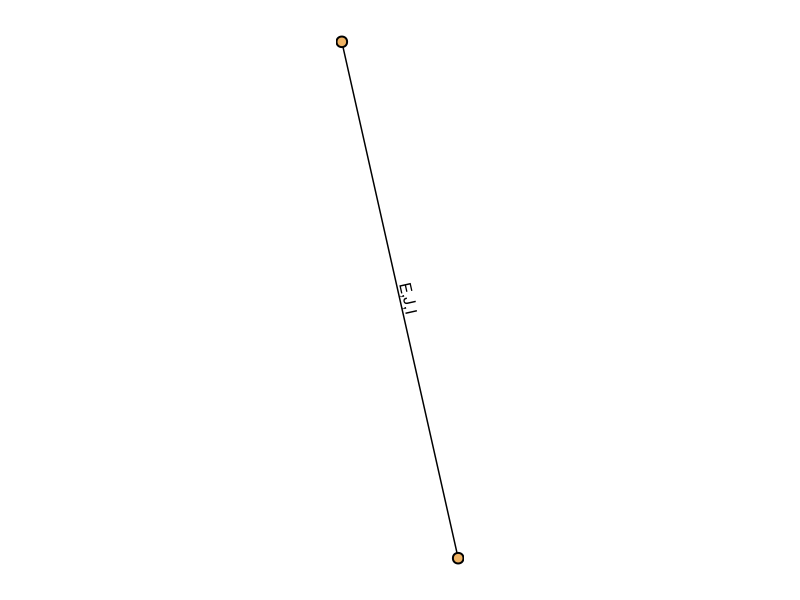

In [7]:
make_plot = true # do you want a visualisation of the TensorNetwork

# Create the tensor network, this will allow me to test my methods
seed1 = 8 
TN = rand(Tenet.TensorNetwork, 10::Integer, 3::Integer; out = 0, dim = 4:4, seed = seed1, globalind = false)
println("Tensor network generated=", TN)

if make_plot == true
    println("Generating plot....")
    # Make a drawing of the tensor network
    # -> Takes a long long time for larger networks...
    drawing = Makie.plot(TN, labels=true)
    display(drawing)
end


initial_contraction = Tenet.contract(TN)[1]

println("Preparing the TensorNetwork for compressed contraction")
println("Performing bond grouping on the whole network")

# Matricization of the tensornetwork
for grouping in generate_groupedbonds(TN)
    if length(grouping) == 1
        continue
    els
        grouping_bondindices(TN, grouping)
    end
end

contract_after_grouping = Tenet.contract(TN)[1]


if make_plot == true
    println("The bond-grouped network:")
    # Make a drawing of the tensor network
    # -> Takes a long long time for larger networks...
    drawing = Makie.plot(TN, labels=true)
    display(drawing)
end


# Compute a greedy contraction sequence -> list of indices
contraction_sequence = EinExprs.einexpr(TN, optimizer=EinExprs.Greedy)
ordered_contraction_indices = EinExprs.inds(contraction_sequence)



chi = 4
# Perform truncated SVD replaced on the whole network
for index in ordered_contraction_indices
    truncated_SVD_replacement(TN, index, chi, false)
    #println("truncated SVD on index  completed")
end

# Contracting the network along the ordered contraction sequence
# -> Problem when two bonds get folded together

make_plot_process = true

for (i, index) in enumerate(ordered_contraction_indices)
    if length(tensors(TN)) == 1
        break
    end
    if index ∉ inds(TN)
        continue
    end
    
    contraction_step(TN, index)
    if make_plot_process == true && length(tensors(TN)) > 1
        # Make a drawing of the tensor network
        # -> Takes a long long time for larger networks...
        drawing1 = Makie.plot(TN, labels=true)
        display(drawing1)
    end
end


compressed_contraction_SVD = tensors(TN)[1][1]


# Comparission of contractions
println("Value of initial network contraction = ", initial_contraction)
# Value after index grouping should be equal to initial contraction
println("Value of contraction after bondgrouping = ", contract_after_grouping)
# Value should differ, should give a better approximation for higher valeus of the bond dimension
println("Value of contraction after truncated_SVD_replacement = ", compressed_contraction_SVD)
# Relative error on the compressed contraction
rel_error = 1 - (compressed_contraction_SVD/initial_contraction)
println("The relative error of approximate contraction = ", rel_error)



The next block of code generates a random tensor network and performs the approximate contraction function based on a sequence of indices. Here, compression steps only take places when the contracted index or group of indices exceed the bondsize limit.

This block of code tries to evaluate the influence of using different bond dimensions on the compressed contraction quality.

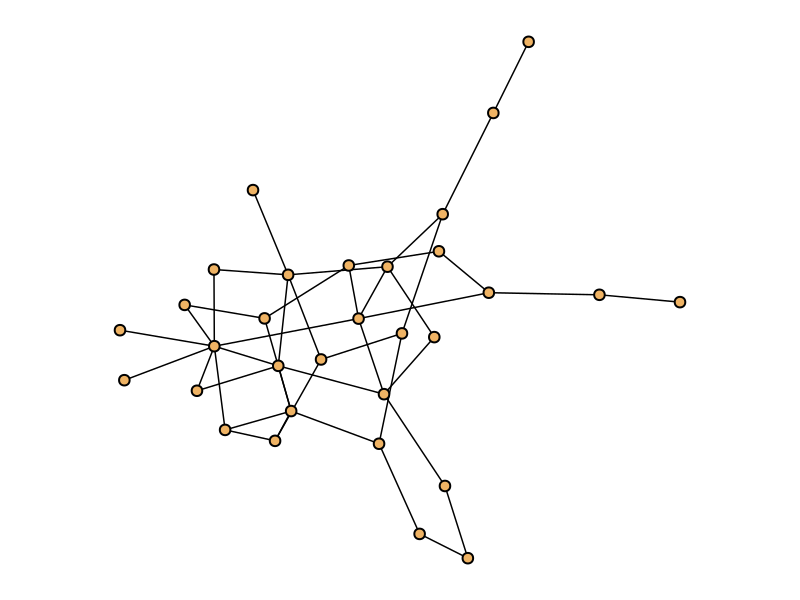

Tensor network generated=TensorNetwork(#tensors=31, #inds=46)
generating plot
Working on chi_max = 1
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
Working on chi_max = 2
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices. Exiting function.
One of the tensors has no non shared indices

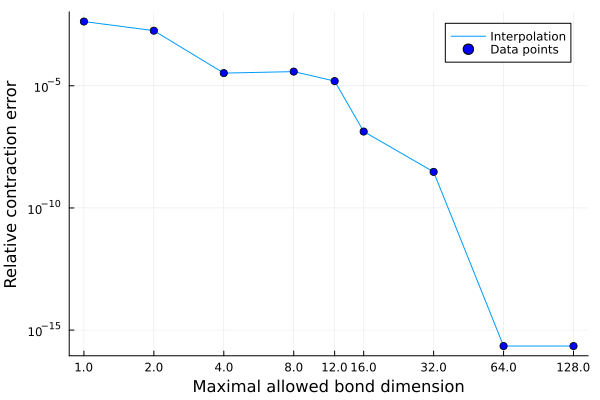

In [10]:
# Generate a random Tensor Network
Makie.inline!(true)
make_plot = true

# Create the tensor network, this will allow me to test my methods
seed1 = 8 
TN = rand(TensorNetwork, 31::Integer, 3::Integer; out = 0, dim = 3:4, seed = seed1, globalind = false)
println("Tensor network generated=", TN)

if make_plot == true
    println("generating plot")
    # Make a drawing of the tensor network
    # -> Takes a long long time for larger networks...
    drawing = Makie.plot(TN)
    display(drawing)
end



# Compute a greedy contraction sequence -> list of indices
contraction_sequence = EinExprs.einexpr(TN, optimizer=EinExprs.Greedy)
#list_ordered_contraction_indices_start = [string(index) for index in EinExprs.inds(contraction_sequence)]

exact_contraction_value = Tenet.contract(TN)[1]
relative_errors = Vector{Float32}()
chi_list = Vector{Float32}()

for chi_max in [1 ,2, 4, 8, 12, 16, 32, 64, 128]
    println("Working on chi_max = ", chi_max)
    TN_editable = copy(TN)
    global list_ordered_contraction_indices = [string(index) for index in EinExprs.inds(contraction_sequence)]
    approximate_contraction_value = approximate_contraction(TN_editable, chi_max, list_ordered_contraction_indices, false, false)
    relative_error = 1 - (approximate_contraction_value/exact_contraction_value)
    push!(relative_errors, relative_error)
    push!(chi_list, chi_max)
end


plot_data = Plots.plot(chi_list, abs.(relative_errors), label="Interpolation", xscale=:log10, yscale=:log10, xticks=(chi_list, chi_list)) #broadcast in onto the relative erorrs instead of calling the function
Plots.plot!(plot_data, chi_list, abs.(relative_errors), seriestype=:scatter, label="Data points", color="blue")
Plots.xlabel!(plot_data,  "Maximal allowed bond dimension")
Plots.ylabel!(plot_data,  "Relative contraction error")

# Display the plot
display(plot_data)